<center><h1>Amazon Web Scrapping</h1></center>

<h4>1) Importing the libraries</h4>



In [60]:
import csv
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import numpy as np
import seaborn as srn
import matplotlib.pyplot as plt

<h4>2) Setting the path of Chrome's driver</h4>

In [61]:
driver = webdriver.Chrome('C:/Users/Alfred/.wdm/drivers/chromedriver/win32/98.0.4758.102/chromedriver.exe')

C:\Users\Alfred\AppData\Local\Temp\ipykernel_8372\1640991319.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/Alfred/.wdm/drivers/chromedriver/win32/98.0.4758.102/chromedriver.exe')


<h4>3) Getting our search parameters</h4>

In [62]:
search_term = input('Write the product name')
minimum = input('Write the minimun value')
maximum = input('Write the maximum value')
search_term = search_term.replace(' ','+')  

Our parameters are: <b>search term</b> (for testing purpose we'll use 'Power Bank'), the <b>minimum value</b> and the  <b>maximum value</b> (these two will be used in the end when the dataframe is generated and polished)

<h4>4) Iterating between products and pages</h4>

A empty list is created to storage our product data throughout the iterations

In [63]:
list_products = []

The next block of code will navigate between the first page to the last one, and the URL will get the three variables that we defined for our search.

The program will get the source code of the URL for each page (first for loop). The products are inside a tag div with a specific name, the program will iterate through the products (second for loop) and scrap five informations:
1) Product Name
2) Price
3) Rating
4) Review Count
5) Link

(I'm not considering sponsored products)<br>
If it returns AtributeError, the variable will receive a NULL value. The result will be a tuple with our 5 variables and after each product, this tuple will be storaged in the variable 'list_products' which is the empty list created right above.

In [64]:
page = 0
for page in range(1,8):
    url = f'https://www.amazon.com.br/s?k={search_term}&page={page}&__mk_pt_BR=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=32CUIJ6TTV5WT&qid=1646248377&sprefix={search_term}%2Caps%2C275&ref=sr_pg_{page}'    

    driver.get(url)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    results = soup.find_all('div', {'data-component-type': 's-search-result'})
    for product in results:
        sponsored_product = product.find('span','a-color-base').text.strip()
        if sponsored_product == "Patrocinados":
            continue
        
        a_tag = product.h2.a
        product_name = a_tag.text.strip()
        link = 'https://www.amazon.com.br' + a_tag.get('href')
        try:
            price_span_tag = product.find('span', 'a-price')
            price = price_span_tag.find('span', 'a-offscreen').text.strip()
        except AttributeError:
            price = ''
                
        try:
            rating_icon = product.find('span','a-icon-alt') .text.strip()
            review_count = product.find('span', {'class': 'a-size-base s-underline-text'}).text
            review_count = str(review_count)
            review_count = review_count.replace('.','')
        except AttributeError:
            rating = ''
            review_count = ''

        result = (product_name, price, rating_icon, review_count, link)
        list_products.append(result)
driver.close()

I previously created a csv file, whose will get the products (list_products) and right after will be transformed in a pandas dataframe

In [65]:
with open('products.csv','w', encoding = 'utf-8') as p:
    writer = csv.writer(p)
    writer.writerow(['PRODUCT DESCRIPTION','PRICE','RATING','REVIEW COUNT','LINK'])
    writer.writerows(list_products)

In [66]:
df = pd.read_csv('products.csv')
df.head()

,PRODUCT DESCRIPTION,PRICE,RATING,REVIEW COUNT,LINK
0,Carregador Portátil (Power Bank) Ultra Rápido ...,NaN,"4,7 de 5 estrelas",971.0,https://www.amazon.com.br/Carregador-Port%C3%A...
1,Power Bank Bateria 10.000 Mah de Polímero Conc...,"R$ 99,90","4,6 de 5 estrelas",77.0,https://www.amazon.com.br/Power-Multilaser-100...
2,POWER BANK 12500MAH - 2 PORTAS USB - LED INDIC...,"R$ 125,10","4,3 de 5 estrelas",49.0,https://www.amazon.com.br/POWER-BANK-12500MAH-...
3,Xiaomi Mi Power Bank 2 10000mah C/2 Usb Quick ...,"R$ 139,90","4,4 de 5 estrelas",181.0,https://www.amazon.com.br/Xiaomi-Power-10000ma...
4,Power Bank 2 Slim Xiaomi 10000mah (Prata),"R$ 129,90","4,6 de 5 estrelas",11.0,https://www.amazon.com.br/Power-Bank-Xiaomi-10...


<h4>5) Doing some EDA (Exploratory Data Analysis)</h4>

Checking the type of each column

In [67]:
print(df.dtypes)

PRODUCT DESCRIPTION     object
PRICE                   object
RATING                  object
REVIEW COUNT           float64
LINK                    object
dtype: object


Checking the number of null values in each column

In [68]:
df.isnull().sum()

PRODUCT DESCRIPTION      0
PRICE                   54
RATING                   0
REVIEW COUNT           197
LINK                     0
dtype: int64

Removing the NAn

In [69]:
df = df.dropna()
df = df.reset_index(drop=True)
df.isnull().sum()

PRODUCT DESCRIPTION    0
PRICE                  0
RATING                 0
REVIEW COUNT           0
LINK                   0
dtype: int64

Treating the 'RATING' column to get only the number

In [70]:
df['RATING'] = df['RATING'].str[:3].replace({',':'.'}, regex=True).astype(float)
df.head()

,PRODUCT DESCRIPTION,PRICE,RATING,REVIEW COUNT,LINK
0,Power Bank Bateria 10.000 Mah de Polímero Conc...,"R$ 99,90",4.6,77.0,https://www.amazon.com.br/Power-Multilaser-100...
1,POWER BANK 12500MAH - 2 PORTAS USB - LED INDIC...,"R$ 125,10",4.3,49.0,https://www.amazon.com.br/POWER-BANK-12500MAH-...
2,Xiaomi Mi Power Bank 2 10000mah C/2 Usb Quick ...,"R$ 139,90",4.4,181.0,https://www.amazon.com.br/Xiaomi-Power-10000ma...
3,Power Bank 2 Slim Xiaomi 10000mah (Prata),"R$ 129,90",4.6,11.0,https://www.amazon.com.br/Power-Bank-Xiaomi-10...
4,Carregador Power Bank Pineng PN-9511 10000mAh ...,"R$ 103,87",4.3,2138.0,https://www.amazon.com.br/Carregador-Pineng-Or...


The column 'REVIEW COUNT' will get only integer values

In [71]:
#df['REVIEW COUNT'] = df['REVIEW COUNT'].replace({'.':''}, regex=True).astype(int)
df['REVIEW COUNT'] = df['REVIEW COUNT'].astype('int')
#df['REVIEW COUNT'] = df['REVIEW COUNT'].str.replace({'.':','},regex=True)
df.head()

,PRODUCT DESCRIPTION,PRICE,RATING,REVIEW COUNT,LINK
0,Power Bank Bateria 10.000 Mah de Polímero Conc...,"R$ 99,90",4.6,77,https://www.amazon.com.br/Power-Multilaser-100...
1,POWER BANK 12500MAH - 2 PORTAS USB - LED INDIC...,"R$ 125,10",4.3,49,https://www.amazon.com.br/POWER-BANK-12500MAH-...
2,Xiaomi Mi Power Bank 2 10000mah C/2 Usb Quick ...,"R$ 139,90",4.4,181,https://www.amazon.com.br/Xiaomi-Power-10000ma...
3,Power Bank 2 Slim Xiaomi 10000mah (Prata),"R$ 129,90",4.6,11,https://www.amazon.com.br/Power-Bank-Xiaomi-10...
4,Carregador Power Bank Pineng PN-9511 10000mAh ...,"R$ 103,87",4.3,2138,https://www.amazon.com.br/Carregador-Pineng-Or...


In [72]:
df.dtypes

PRODUCT DESCRIPTION     object
PRICE                   object
RATING                 float64
REVIEW COUNT             int32
LINK                    object
dtype: object

Removing the 'R$' part from the price

In [73]:
remove_coin = df['PRICE'].str.split('$').str[1]
df['PRICE'] = remove_coin.str.strip()
#price_integer = 


To correct the column 'Price' i had to split the numbers in two parts (integer part and decimal part) and replace ',' to a empty value. Then I had to put these two parts together again with '.' to separate them. It's a not so pretty solution but it worked, and I intend to optimize this part.

<h5>Splitting and Replacing</h5>

In [75]:

df['integer_part'] = df['PRICE'].str.split(',').str[0]
df['integer_part'] = df['integer_part'].str.replace('.','')
df['integer_part']

C:\Users\Alfred\AppData\Local\Temp\ipykernel_8372\1546184746.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['integer_part'] = df['integer_part'].str.replace('.','')


0      99
1     125
2     139
3     129
4     103
     ... 
90    252
91     64
92    189
93     97
94     63
Name: integer_part, Length: 95, dtype: object

In [76]:
df['decimal_part'] = df['PRICE'].str.split(',').str[1]
df['decimal_part']

0     90
1     10
2     90
3     90
4     87
      ..
90    53
91    90
92    00
93    50
94    28
Name: decimal_part, Length: 95, dtype: object

<h5>Joining the parts</h5>

In [77]:
df['PRICE_CORRECT'] = df['integer_part'] + "." + df['decimal_part']
df['PRICE_CORRECT'] = df['PRICE_CORRECT'].astype('string')
df['PRICE_CORRECT'] = df['PRICE_CORRECT'].astype('float')

In [78]:
df['PRICE'] = df['PRICE_CORRECT']
df.drop(['integer_part','decimal_part','PRICE_CORRECT'], axis=1, inplace=True)


Now that the dataframe is polished, let's check how the variables 'Rating' and 'Price' are distributed. It's possible to see that the most part of Power Banks in Amazon have a sort of good quality, due to de high rating. And the Average price is R$100,00 with some outliers. 

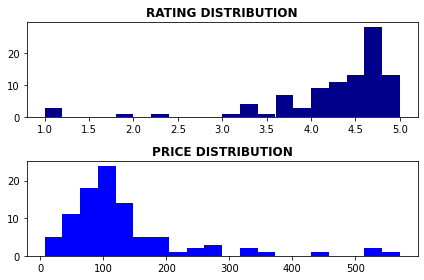

In [79]:

plt.figure()
plt.subplot(2,1,1)
plt.hist(df['RATING'], color='darkblue', bins=20)
plt.title('RATING DISTRIBUTION', fontweight="bold")
plt.subplot(2,1,2)
plt.hist(df['PRICE'], color='blue', bins=20)
plt.title('PRICE DISTRIBUTION', fontweight="bold")
plt.locator_params('x', nbins=8)

plt.tight_layout()

In [80]:
df.head()

,PRODUCT DESCRIPTION,PRICE,RATING,REVIEW COUNT,LINK
0,Power Bank Bateria 10.000 Mah de Polímero Conc...,99.90,4.6,77,https://www.amazon.com.br/Power-Multilaser-100...
1,POWER BANK 12500MAH - 2 PORTAS USB - LED INDIC...,125.10,4.3,49,https://www.amazon.com.br/POWER-BANK-12500MAH-...
2,Xiaomi Mi Power Bank 2 10000mah C/2 Usb Quick ...,139.90,4.4,181,https://www.amazon.com.br/Xiaomi-Power-10000ma...
3,Power Bank 2 Slim Xiaomi 10000mah (Prata),129.90,4.6,11,https://www.amazon.com.br/Power-Bank-Xiaomi-10...
4,Carregador Power Bank Pineng PN-9511 10000mAh ...,103.87,4.3,2138,https://www.amazon.com.br/Carregador-Pineng-Or...


Organizing the data to show the most reviwed and most rated products first

In [81]:
df.sort_values(by=['REVIEW COUNT','RATING'], inplace=True, ascending=False)
df.head()

,PRODUCT DESCRIPTION,PRICE,RATING,REVIEW COUNT,LINK
55,Rádio meteorológico de emergência FosPower NOA...,515.47,4.6,18438,https://www.amazon.com.br/port%C3%A1til-emerg%...
64,Smartwatch Xiaomi Mi Band 4 Oled Preto Origina...,152.00,4.8,17521,https://www.amazon.com.br/Smartwatch-Xiaomi-Pr...
40,Multiplicador 4 Tomadas Bivolt + 2 USB 2.4A - ...,69.90,4.8,7584,https://www.amazon.com.br/Multiplicador-Tomada...
57,Motorola MO-SKN6473AIBI - Cabo de Dados USB/US...,21.50,4.7,7530,https://www.amazon.com.br/Dados-USB-C-Inbulk-L...
76,"Capa de disco rígido externo UGREEN 2,5 polega...",108.00,4.7,7469,https://www.amazon.com.br/UGREEN-polegadas-ele...


Let's consider that the most rated and most reviwed products are the best of the list. Then the is shown only the name, price and link

In [82]:
top10_best_products = df[['PRODUCT DESCRIPTION', 'PRICE','LINK']]
top10_best_products.head()

,PRODUCT DESCRIPTION,PRICE,LINK
55,Rádio meteorológico de emergência FosPower NOA...,515.47,https://www.amazon.com.br/port%C3%A1til-emerg%...
64,Smartwatch Xiaomi Mi Band 4 Oled Preto Origina...,152.00,https://www.amazon.com.br/Smartwatch-Xiaomi-Pr...
40,Multiplicador 4 Tomadas Bivolt + 2 USB 2.4A - ...,69.90,https://www.amazon.com.br/Multiplicador-Tomada...
57,Motorola MO-SKN6473AIBI - Cabo de Dados USB/US...,21.50,https://www.amazon.com.br/Dados-USB-C-Inbulk-L...
76,"Capa de disco rígido externo UGREEN 2,5 polega...",108.00,https://www.amazon.com.br/UGREEN-polegadas-ele...


Now it shows the top 10 products in the range that was defined in the beginning with the variables 'minimum' and 'maximum'

In [83]:
top10_best_products.loc[(top10_best_products['PRICE'] >= float(minimum)) & (top10_best_products['PRICE'] < float(maximum))].head(10)

,PRODUCT DESCRIPTION,PRICE,LINK
64,Smartwatch Xiaomi Mi Band 4 Oled Preto Origina...,152.00,https://www.amazon.com.br/Smartwatch-Xiaomi-Pr...
40,Multiplicador 4 Tomadas Bivolt + 2 USB 2.4A - ...,69.90,https://www.amazon.com.br/Multiplicador-Tomada...
76,"Capa de disco rígido externo UGREEN 2,5 polega...",108.00,https://www.amazon.com.br/UGREEN-polegadas-ele...
29,"Bateria Externa, 10,000Mah USB Tipo C Prata, S...",339.99,https://www.amazon.com.br/Bateria-Externa-R%C3...
4,Carregador Power Bank Pineng PN-9511 10000mAh ...,103.87,https://www.amazon.com.br/Carregador-Pineng-Or...
48,"Carregador Universal Ultra Rápido Duo, 1 X USB...",79.90,https://www.amazon.com.br/Carregador-Universal...
39,Bateria Externa Carga Rápida Wireless 10000 MA...,339.00,https://www.amazon.com.br/Bateria-Externa-R%C3...
9,"Carregador Portátil 12.000 mAh, Azul Marinho, ...",119.00,https://www.amazon.com.br/Carregador-Port%C3%A...
84,"Carregador de tomada PowerPort, 2 portas USB, ...",119.00,https://www.amazon.com.br/Carregador-Tomada-Po...
21,Carregador Portatil Powerbank Xiaomi 10000mah ...,119.53,https://www.amazon.com.br/Carregador-Portatil-...
